In [1]:
# Imports
import pykep as pk
import pygmo as pg
import numpy as np
from pykep.orbit_plots import plot_planet, plot_lambert
from pykep import AU, DAY2SEC
import pygmo_plugins_nonfree as ppnf

# Plotting imports
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

## Testing random examples in pykep

### Example 1: Multiple impulses transfer between Earth and Venus

In [2]:
# We define the optimization problem
udp = pk.trajopt.pl2pl_N_impulses(
    start=pk.planet.jpl_lp('earth'),
    target=pk.planet.jpl_lp('venus'),
    N_max=3,
    tof=[100., 1000.],
    vinf=[0., 4],
    phase_free=False,
    multi_objective=False,
    t0=[pk.epoch(0), pk.epoch(1000)])
# All pykep problems in the module trajopt are compatible with pygmo.
# So we create a pygmo problem from the pykep udp (User Defined Problem)
prob = pg.problem(udp)
print(prob)

Problem name: <class 'pykep.trajopt._pl2pl_N_impulses.pl2pl_N_impulses'>
	C++ class name: pybind11::object

	Global dimension:			7
	Integer dimension:			0
	Fitness dimension:			1
	Number of objectives:			1
	Equality constraints dimension:		0
	Inequality constraints dimension:	0
	Lower bounds: [0, 100, 0.001, 0, 0, ... ]
	Upper bounds: [1000, 1000, 0.999, 1, 1, ... ]
	Has batch fitness evaluation: false

	Has gradient: false
	User implemented gradient sparsity: false
	Has hessians: false
	User implemented hessians sparsity: false

	Fitness evaluations: 0

	Thread safety: none



In [3]:
# Here we define the solution strategy, which in this simple case is to use
# Covariance Matrix adaptation Evolutionary Strategy (CMA-ES)
uda = pg.cmaes(gen=1000, force_bounds = True)
algo = pg.algorithm(uda)
# Here we activate some degree of screen output (will only show in the terminal)
algo.set_verbosity(10)
# We construct a random population of 20 individuals (the initial guess)
pop = pg.population(prob, size = 20, seed = 123)
# We solve the problem
pop = algo.evolve(pop)

CMAES 4 PaGMO: 
mu: 10 - lambda: 20 - mueff: 5.9388 - N: 7
cc: 0.38186 - cs: 0.442549 - c1: 0.0267277 - cmu: 0.0944846 - sigma: 0.5 - damps: 1.44255 - chiN: 2.55383

   Gen:        Fevals:          Best:            dx:            df:         sigma:
      1              0        9706.34         857.52         818649            0.5
     11            200        19614.1        184.717        66407.6       0.237263
     21            400        10324.2        561.113        40165.5        0.10268
     31            600         6438.5        47.3957        46817.3      0.0794365
     41            800        6156.28         141.76          45190      0.0401805
     51           1000        6160.63        91.6942        34935.2      0.0420491
     61           1200        6105.17        11.4805        1677.99      0.0151286
     71           1400        6077.37        53.8339        65363.1       0.018673
     81           1600         6061.4        25.4988        3123.76      0.0217117
    

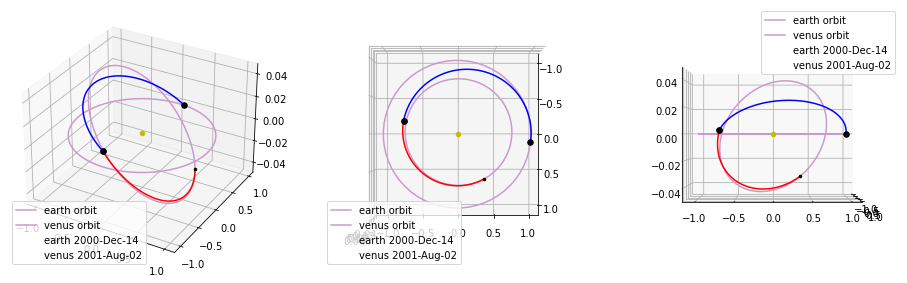

In [4]:
# Plot our trajectory
fig = plt.figure(figsize = (16,5))
ax1 = fig.add_subplot(1, 3, 1, projection='3d')
ax2 = fig.add_subplot(1, 3, 2, projection='3d')
ax3 = fig.add_subplot(1, 3, 3, projection='3d')
ax1 = udp.plot(pop.champion_x, axes = ax1)
ax2 = udp.plot(pop.champion_x, axes = ax2)
ax2.view_init(elev=90, azim=0)
ax3 = udp.plot(pop.champion_x, axes = ax3)
ax3.view_init(elev=0, azim=0)

In [5]:
# Inspect
udp.pretty(pop.champion_x)

Total DV (m/s):  5586.571466417641
Dvs (m/s):  [2426.2601735776957, 2648.1952838500833, 512.1160089898622]
Tofs (days):  [144.85597071586642, 85.8151695307143]


### Example 2: Multi revolutions Lambert Problem

In [6]:
# We define the Lambert problem
t1 = pk.epoch(0)
t2 = pk.epoch(640)
dt = (t2.mjd2000 - t1.mjd2000) * DAY2SEC

earth = pk.planet.jpl_lp('earth')
rE, vE = earth.eph(t1)

mars = pk.planet.jpl_lp('mars')
rM, vM = mars.eph(t2)

# We solve the Lambert problem
l = pk.lambert_problem(r1 = rE, r2 = rM, tof = dt, mu = pk.MU_SUN, max_revs=2)

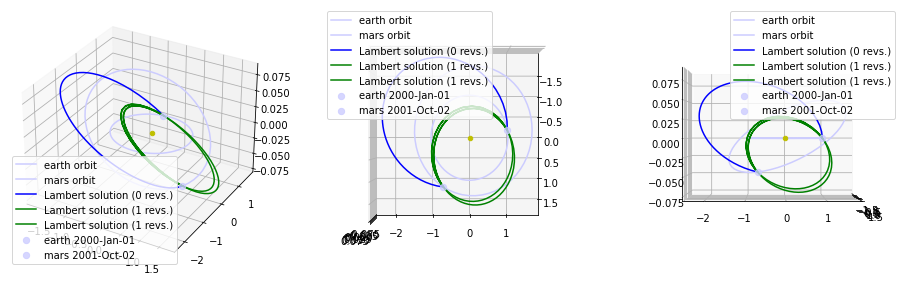

In [7]:
# We plot
mpl.rcParams['legend.fontsize'] = 10

# Create the figure and axis
fig = plt.figure(figsize = (16,5))
ax1 = fig.add_subplot(1, 3, 1, projection='3d')
ax1.scatter([0], [0], [0], color=['y'])

ax2 = fig.add_subplot(1, 3, 2, projection='3d')
ax2.scatter([0], [0], [0], color=['y'])
ax2.view_init(90, 0)

ax3 = fig.add_subplot(1, 3, 3, projection='3d')
ax3.scatter([0], [0], [0], color=['y'])
ax3.view_init(0,0)

for ax in [ax1, ax2, ax3]:
    # Plot the planet orbits
    plot_planet(earth, t0=t1, color=(0.8, 0.8, 1), legend=True, units=AU, axes=ax)
    plot_planet(mars, t0=t2, color=(0.8, 0.8, 1), legend=True, units=AU, axes=ax)
    # Plot the Lambert solutions
    axis = plot_lambert(l, color='b', legend=True, units=AU, axes=ax)
    axis = plot_lambert(l, sol=1, color='g', legend=True, units=AU, axes=ax)
    axis = plot_lambert(l, sol=2, color='g', legend=True, units=AU, axes=ax)

### Example 3: Mass optimal Mars Randezvous using a direct method


 objevals:        objval:      violated:    viol. norm:
         1       -132.815             22         5.1042 i
         2       -931.111             48        13.7759 i
         3        -505.97             23        2.14353 i
         4        -505.97             23        2.14353 i
         5       -822.218             48        9.29475 i
         6          -1000             35        4.05905 i
         7       -942.355             46        6.72091 i
         8       -925.828             44        7.90637 i
         9       -933.647             37        3.58608 i
        10       -933.647             37        3.58608 i
        11       -929.429             47        10.7962 i
        12       -932.768             34        2.72227 i
        13       -932.768             34        2.72227 i
        14       -887.188             47         9.2815 i
        15       -926.249             33        2.40977 i
        16       -926.249             33        2.40977 i
        17     

       277        -876.58         No solution found, try again :)

Low-thrust NEP transfer from earth to mars

Launch epoch: 1300.471732747767 MJD2000, a.k.a. 2003-Jul-24 11:19:17.709407
Arrival epoch: 2049.0984828086775 MJD2000, a.k.a. 2005-Aug-11 02:21:48.914670
Time of flight (days): 748.6267500609106 

Launch DV (km/s) 3.5000028996260624 - [2.2700606334896327,2.2145285271851294,1.4807796662416568]
Arrival DV (km/s) 1.0763764223985582e-06 - [3.664353262533175e-07,9.975516876599545e-07,-1.7088588243597072e-07]

Spacecraft Initial Position (m)  : [78551876715.61655, -130093180334.7451, 1081008.6346302629]
Spacecraft Initial Velocity (m/s): [27285.660187429174, 17500.6272326824, 1480.652646480529]
Spacecraft Initial Mass  (kg)    : 1000.0
Spacecraft Final Position (m)  : [205050717251.29178, -29964437388.833893, -5665148894.05915]
Spacecraft Final Velocity (m/s): [4433.008452054156, 26044.116394159195, 436.7172865917746]
Spacecraft Final Mass  (kg)    : 874.3523773396408


/opt/anaconda3/envs/pykep/lib/python3.9/site-packages/pykep/trajopt/_direct.py:73: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  axes = fig.gca(projection='3d')


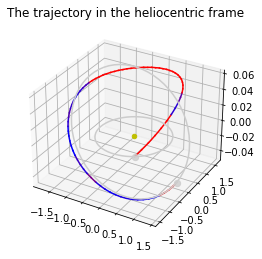

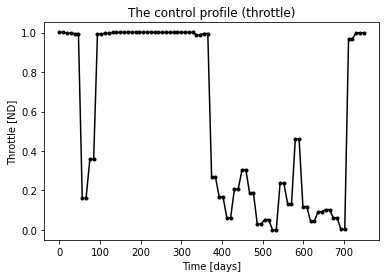

In [8]:
def run_example8(nseg=40):
    """
    This example demonstrates the direct method (sims-flanagan) on a planet to planet scenario.
    """
    import pykep as pk
    import pygmo as pg
    import numpy as np
    from matplotlib import pyplot as plt
    from pykep.examples import add_gradient, algo_factory

    # 1 - Algorithm
    algo = algo_factory("slsqp")

    # 2 - Problem
    udp = add_gradient(pk.trajopt.direct_pl2pl(
        p0="earth",
        pf="mars",
        mass=1000,
        thrust=0.1,
        isp=3000,
        vinf_arr=1e-6,
        vinf_dep=3.5,
        hf=False,
        nseg=nseg,
        t0=[1100, 1400],
        tof=[200, 750]),
        with_grad=True
    )

    prob = pg.problem(udp)
    prob.c_tol = [1e-5] * prob.get_nc()

    # 3 - Population
    pop = pg.population(prob, 1)

    # 4 - Solve the problem (evolve)
    pop = algo.evolve(pop)

    # 5 - Inspect the solution
    if prob.feasibility_x(pop.champion_x):
        print("Optimal Found!!")
    else:
        print("No solution found, try again :)")

    udp.udp_inner.pretty(pop.champion_x)

    axis = udp.udp_inner.plot_traj(pop.champion_x)
    plt.title("The trajectory in the heliocentric frame")
    axis = udp.udp_inner.plot_control(pop.champion_x)
    plt.title("The control profile (throttle)")

    plt.ion()
    plt.show()


if __name__ == "__main__":
    run_example8()

  22      0.0300329 i
       496       -891.419             22      0.0300329 i
       497        -891.92             23       0.128065 i
       498       -891.559             22      0.0284737 i
       499       -891.559             22      0.0284737 i
       500       -891.097             22      0.0279826 i

 objevals:        objval:      violated:    viol. norm:
       501       -891.335             22      0.0200189 i
       502       -891.335             22      0.0200189 i
       503       -891.218             22      0.0410879 i
       504       -891.303             22      0.0163062 i
       505       -891.303             22      0.0163062 i
       506       -891.107             22      0.0208228 i
       507       -891.242             22      0.0125877 i
       508       -891.242             22      0.0125877 i
       509       -891.296             22      0.0272186 i
       510       -891.251             22        0.01121 i
       511       -891.245             22      0.011

/opt/anaconda3/envs/pykep/lib/python3.9/site-packages/pykep/trajopt/_direct.py:73: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  axes = fig.gca(projection='3d')


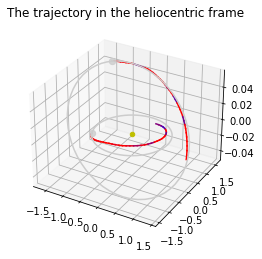

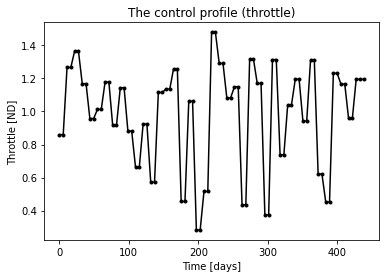

In [10]:
run_example8()

)

 objevals:        objval:      violated:    viol. norm:
         1       -409.446             24        3.08885 i
         2          -1000             47        11.4874 i
         3       -949.664             47        10.5073 i
         4       -911.843             47        8.90011 i
         5       -888.464             47        5.61562 i
         6       -888.703             47        6.74883 i
         7       -888.558             47        4.26752 i
         8       -888.558             47        4.26752 i
         9        -878.19             47        8.17991 i
        10       -886.566             47        3.69032 i
        11       -886.566             47        3.69032 i
        12       -852.797             47        7.97546 i
        13       -883.189             47        3.36259 i
        14       -883.189             47        3.36259 i
        15        -859.51             47        8.33683 i
        16       -880.084             47        3.04385 i
        17   

       277       -886.294             24      0.0741895 i
       278       -886.294             24      0.0741895 i
       279       -886.871             28       0.439664 i
       280       -886.378             24      0.0712514 i
       281       -886.378             24      0.0712514 i
       282       -890.914             30        1.00542 i
       283       -886.837             25      0.0714926 i
       284       -886.837             25      0.0714926 i
       285        -894.51             30        2.37668 i
       286       -887.604             25      0.0810976 i
       287       -887.604             25      0.0810976 i
       288       -888.864             27       0.685467 i
       289       -887.764             25      0.0790788 i
       290       -887.764             25      0.0790788 i
       291       -890.197             29        0.68151 i
       292       -888.076             25      0.0776306 i
       293       -888.076             25      0.0776306 i
       294    

       5No solution found, try again :)

Low-thrust NEP transfer from earth to mars

Launch epoch: 1266.856408121492 MJD2000, a.k.a. 2003-Jun-20 20:33:13.661697
Arrival epoch: 1981.603419366812 MJD2000, a.k.a. 2005-Jun-04 14:28:55.433293
Time of flight (days): 714.7470112453199 

Launch DV (km/s) 3.499999114296765 - [2.820885452280446,0.4909427732425006,-2.012852269440469]
Arrival DV (km/s) 1.0786501901054085e-06 - [7.418123399378074e-07,4.3156060199061905e-07,-6.534188027137903e-07]

Spacecraft Initial Position (m)  : [-2488199883.6179314, -152002162245.4056, 1231450.6185795367]
Spacecraft Initial Velocity (m/s): [32120.59986893865, -108.15937702962634, -2012.8474157942928]
Spacecraft Initial Mass  (kg)    : 1000.0
Spacecraft Final Position (m)  : [131288580252.62231, -161971754146.14716, -6618645608.740125]
Spacecraft Final Velocity (m/s): [19741.825198405248, 17332.651613300288, -121.88176516330073]
Spacecraft Final Mass  (kg)    : 891.1202632213381


/opt/anaconda3/envs/pykep/lib/python3.9/site-packages/pykep/trajopt/_direct.py:73: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  axes = fig.gca(projection='3d')


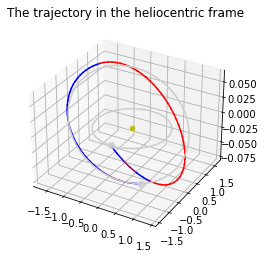

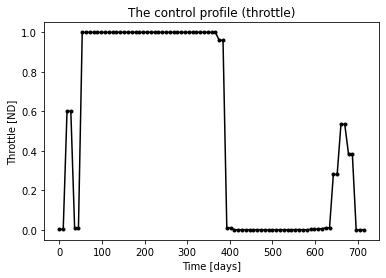

In [11]:
run_example8()